In [1]:
import os
from sklearn.model_selection import train_test_split
import cv2  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def convert_to_gray(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray_img

def convert_to_lab(img):
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    return lab_img

def extract_a_channel(lab_img):
    a_channel = lab_img[:, :, 1]

    return a_channel

def apply_clahe(a_channel):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    equalized_a_channel = clahe.apply(a_channel)
    return equalized_a_channel

def dilate_image(img):
    kernel = np.ones((3, 3), np.uint8)
    dilated_img = cv2.dilate(img, kernel, iterations=1)

    return dilated_img

def apply_threshold(img):
    _, thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresholded_img

def preprocess_image(img):
    gray_img = convert_to_gray(img)
    lab_img = convert_to_lab(img)
    a_channel = extract_a_channel(lab_img)
    equalized_a_channel = apply_clahe(a_channel)
    dilated_img = dilate_image(equalized_a_channel)
    thresholded_img = apply_threshold(dilated_img)
    thresholded_img = np.expand_dims(thresholded_img, axis=-1)
    color_img = np.repeat(thresholded_img, 3, axis=-1)
    return color_img




In [3]:
def load_images_from_folder(folder, target_size=(256, 256), test_size=0.2):
    images = []
    labels = []

    for label, class_folder in enumerate(os.listdir(folder)):
        class_path = os.path.join(folder, class_folder)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                preprocessed_img = preprocess_image(img)
                images.append(preprocessed_img)
                labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

In [5]:
folder_path = 'C:\SUDHARSHAN\miniProject\Dataset'
i=0
X_train, X_test, y_train, y_test = load_images_from_folder(folder_path)



In [6]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1440, 256, 256, 3)
X_test shape: (360, 256, 256, 3)
y_train shape: (1440,)
y_test shape: (360,)


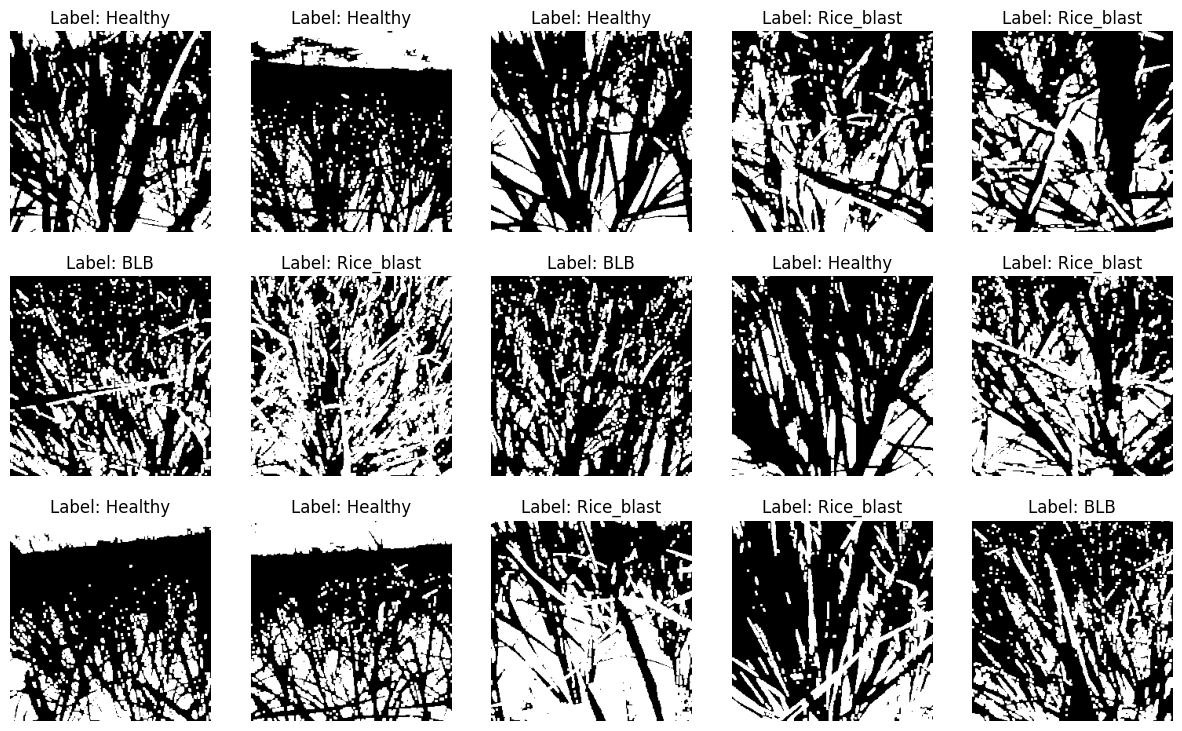

In [7]:
import matplotlib.pyplot as plt

mappings={0:"Healthy",1:"Rice_blast",2:"BLB"}
def visualize_images(images, labels):
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i],cmap = "summer")
        ax.set_title(f"Label: {mappings[labels[i]]}")
        ax.axis('off')
    plt.show()

visualize_images(X_train[15:30], y_train[15:30])


In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
import tensorflow as tf

def create_model():
    
    def add_conv_block(model, num_filters):
        
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(256, 256,3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    model = add_conv_block(model, 256)

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 64)      1

In [10]:
%%time

rice_bios_model = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=250, batch_size=128
    )

Epoch 1/250
12/12 [==============================] - 182s 15s/step - loss: 2.8830 - accuracy: 0.3500 - val_loss: 1.3132 - val_accuracy: 0.3056
Epoch 2/250
12/12 [==============================] - 183s 15s/step - loss: 1.1023 - accuracy: 0.3632 - val_loss: 1.2475 - val_accuracy: 0.4194
Epoch 3/250
12/12 [==============================] - 190s 16s/step - loss: 1.0089 - accuracy: 0.4604 - val_loss: 5.1638 - val_accuracy: 0.2917
Epoch 4/250
12/12 [==============================] - 200s 17s/step - loss: 0.9781 - accuracy: 0.5174 - val_loss: 12.4187 - val_accuracy: 0.2917
Epoch 5/250
12/12 [==============================] - 216s 18s/step - loss: 0.9298 - accuracy: 0.5618 - val_loss: 4.5419 - val_accuracy: 0.3250
Epoch 6/250
12/12 [==============================] - 216s 18s/step - loss: 0.8819 - accuracy: 0.5868 - val_loss: 4.0067 - val_accuracy: 0.3139
Epoch 7/250
12/12 [==============================] - 216s 18s/step - loss: 0.8223 - accuracy: 0.6194 - val_loss: 2.2735 - val_accuracy: 0.369

In [11]:
training_accuracy = rice_bios_model.history['accuracy'][-1]
validation_accuracy = rice_bios_model.history['val_accuracy'][-1]

print("Training Accuracy:", training_accuracy)
print("Validation Accuracy:", validation_accuracy)

Training Accuracy: 0.9888888597488403
Validation Accuracy: 0.8777777552604675


In [13]:
model.save('RB_Model.h5')

C:\Users\sasye\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


# Evaluate model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes))

12/12 [==============================] - 6s 496ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       127
           1       0.89      0.88      0.88       105
           2       0.91      0.88      0.90       128

    accuracy                           0.91       360
   macro avg       0.90      0.90      0.90       360
weighted avg       0.91      0.91      0.91       360



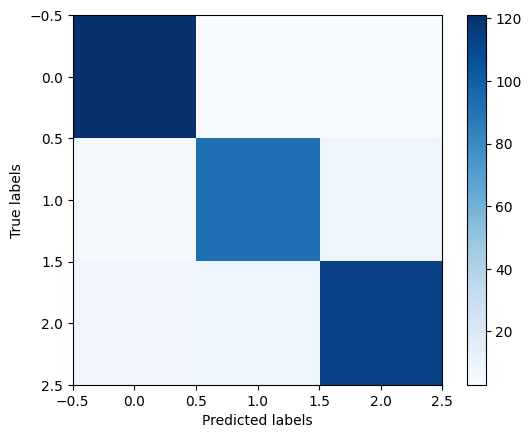

In [16]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()